In [85]:
import os
import shapefile
import geopandas as gpd
import laspy
from scipy import spatial
import whitebox
import CSF
from osgeo import osr, ogr
import rasterio
from skimage import io
import numpy as np
from matplotlib import pyplot as plt

In [86]:
# Region of interest extraction
def make_polygon(rtk_shapefile_path, image_file_path=None, epsg=None):
    if image_file_path is not None:
        # Retrieve EPSG from Image File
        with rasterio.open(image_file_path) as src:
            epsg = src.crs.to_epsg()
    elif epsg is None:
        raise ValueError("Either 'image_file_path' or 'epsg' must be provided.")
    
    # Read RTK File
    sf = shapefile.Reader(rtk_shapefile_path)
    shapes = sf.shapes()
    rtk_points = [shape.points[0] for shape in shapes]
    
    rtk_dir, rtk_name = os.path.split(rtk_shapefile_path)
    polygon_shapefile_path = os.path.join(rtk_dir, 'polygon.shp')
    
    # Create Polygon Shapefile
    driver = ogr.GetDriverByName("ESRI Shapefile")
    data_source = driver.CreateDataSource(polygon_shapefile_path)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    layer = data_source.CreateLayer("polygon", srs, ogr.wkbMultiPolygon)
    
    # Read the corresponding feature type from the layer and create a feature
    feature = ogr.Feature(layer.GetLayerDefn())
    wkt = 'POLYGON (({} {},{} {},{} {},{} {},{} {}))'.format(
        rtk_points[0][0], rtk_points[0][1],
        rtk_points[1][0], rtk_points[1][1],
        rtk_points[2][0], rtk_points[2][1],
        rtk_points[3][0], rtk_points[3][1],
        rtk_points[0][0], rtk_points[0][1])
    polygon = ogr.CreateGeometryFromWkt(wkt)
    feature.SetGeometry(polygon)
    layer.CreateFeature(feature)
    
    feature = None
    data_source = None
    
    # Visualize ROI Points and Polygons
    sf_m = gpd.read_file(rtk_shapefile_path)
    sf_po = gpd.read_file(polygon_shapefile_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    ax = axes.ravel()
    sf_m.plot(color='red', markersize=50, ax=ax[0])
    ax[0].set_title('ROI Points')
    sf_po.boundary.plot(color="red", zorder=10, ax=ax[1])
    ax[1].set_title('ROI Polygon')
    plt.tight_layout()
    plt.show()
    
    return polygon_shapefile_path, rtk_points

In [87]:
# point cloud denosing(Statistical Outlier Removal，SOR)
def denoising(input_las_file_path, polygon_shapefile_path):
    las_dir, las_name = os.path.split(input_las_file_path)
    roi_las_name = "roi_" + las_name
    roi_las_path = os.path.join(las_dir, roi_las_name)
    
    wbt = whitebox.WhiteboxTools()
    wbt.clip_lidar_to_polygon(
        i=input_las_file_path, 
        polygons=polygon_shapefile_path, 
        output=roi_las_path
    )
    
    # Read and Process Point Cloud Data in Chunks
    sigma = 5
    K = 20
    chunk_size = 5000000
    k_dist = []
    with laspy.open(roi_las_path) as las:
        num_points = las.header.point_count
        total_chunks = (num_points + chunk_size - 1) // chunk_size
        for i in range(0, num_points, chunk_size):
            chunk_number = i // chunk_size + 1
            print(f"Processing chunk {chunk_number} / {total_chunks}")
            chunk = las.read_points(chunk_size)
            x, y, z = chunk.x, chunk.y, chunk.z
            lasdata = np.vstack((x, y, z)).transpose()
            
            tree = spatial.KDTree(lasdata)
            dist, _ = tree.query(lasdata, K, workers=4)
            k_dist.extend(np.sum(dist, axis=1))
    
    # Determine the Maximum Threshold for Noise
    max_distance = np.mean(k_dist) + sigma * np.std(k_dist)
    
    # Index of Noise
    outer_index = np.where(np.array(k_dist) > max_distance)
    sor_filter = np.array(k_dist) <= max_distance
    
    denoised_las_file_path = os.path.join(las_dir, 'sor_' + roi_las_name)
    with laspy.open(roi_las_path) as las:
        points = las.read_points(las.header.point_count)
        denoised_points = points[sor_filter]
        with laspy.open(denoised_las_file_path, mode='w', header=las.header) as out_las:
            out_las.write_points(denoised_points)
    
    return denoised_las_file_path, roi_las_name

In [88]:
# Ground Filtering
def ground_filtering(denoised_las_file_path, resolution, threshold):
    las_dir, sor_name = os.path.split(denoised_las_file_path)
    with laspy.open(denoised_las_file_path) as las_sor:
        points = las_sor.read_points(las_sor.header.point_count)
        xyz_sor = np.vstack((points.x, points.y, points.z)).transpose()
    
    csf = CSF.CSF()
    csf.params.bSloopSmooth = False
    csf.params.cloth_resolution = resolution
    csf.params.class_threshold = threshold
    csf.setPointCloud(xyz_sor)
    ground = CSF.VecInt()
    non_ground = CSF.VecInt()
    csf.do_filtering(ground, non_ground)
    
    def save_points(points, file_name):
        file_path = os.path.join(las_dir, file_name)
        with laspy.open(denoised_las_file_path) as las_sor:
            point_data = las_sor.read_points(las_sor.header.point_count)
            filtered_points = point_data[list(points)]
            with laspy.open(file_path, mode='w', header=las_sor.header) as out_las:
                out_las.write_points(filtered_points)
        return file_path
    
    ground_points_file_path = save_points(ground, 'ground_' + sor_name)
    above_ground_points_file_path = save_points(non_ground, 'above_ground_' + sor_name)
    
    return ground_points_file_path

In [116]:
# Generate Canopy Height Model (CHM)
def make_chm(ground_points_file_path, denoised_las_file_path, las_name, polygon_shapefile_path):
    wbt = whitebox.WhiteboxTools()
    las_dir, _ = os.path.split(denoised_las_file_path)
    
    with laspy.open(ground_points_file_path) as las_ground:
        ground_points = las_ground.read_points(las_ground.header.point_count)
        z_ground = ground_points.z
    
    above_ground_las_path = os.path.join(las_dir, 'sor_above_' + las_name)
    # point cloud slice
    wbt.lidar_elevation_slice(
        i=denoised_las_file_path,
        output=above_ground_las_path,
        minz=z_ground.min(),
        maxz=None,
        cls=False
    )
    
    above_ground_tif_path = os.path.join(las_dir, 'sor_above_' + las_name[:-4] + '.tif')
    # point cloud tin griding
    wbt.lidar_tin_gridding(i=above_ground_las_path,
                           output=above_ground_tif_path,
                           parameter="elevation",
                           returns="all",
                           resolution=0.01,
                           minz=None,
                           maxz=None,
                           max_triangle_edge_length=None)
    ground_tif_path = os.path.join(las_dir, 'ground_' + las_name[:-4] + '.tif')
    wbt.lidar_tin_gridding(
        i=ground_points_file_path,
        output=ground_tif_path,
        parameter="elevation",
        returns="all",
        resolution=0.01,
        minz=None,
        maxz=None,
        max_triangle_edge_length=None
    )
    # make polygon
    wbt.clip_raster_to_polygon(
        i=above_ground_tif_path,
        polygons=polygon_shapefile_path,
        output=above_ground_tif_path
    )
    wbt.clip_raster_to_polygon(
        i=ground_tif_path,
        polygons=polygon_shapefile_path,
        output=ground_tif_path
    )

    with rasterio.open(ground_tif_path) as src:
        dem_im = src.read(1, masked=True)
        print(f"DEM: {src.meta}")

    with rasterio.open(above_ground_tif_path) as src:
        dsm_im = src.read(1, masked=True)
        dsm_meta = src.profile
        print(f"DSM: {src.meta}")
    # make CHM
    chm = dsm_im - dem_im
    nodatavalue = chm.min()
    chm_fi = np.ma.filled(chm, fill_value=nodatavalue)

    chm_meta = dsm_meta.copy()
    chm_meta.update({'nodata': nodatavalue})

    canopy_height_model_file_path = os.path.join(las_dir, 'chm_' + las_name[:-4] + '.tif')
    with rasterio.open(canopy_height_model_file_path, 'w', **chm_meta) as ff:
        ff.write(chm_fi, 1)

    return canopy_height_model_file_path

In [117]:
# CHM Visualization
def visualize_chm(canopy_height_model_file_path):
    img = io.imread(canopy_height_model_file_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(img, cmap=plt.cm.gray)
    axes[0].set_title('CHM (Grayscale)')
    axes[1].imshow(img, cmap=plt.cm.jet)
    axes[1].set_title('CHM (Jet)')
    plt.tight_layout()

# Drone - Dormancy Stage

In [118]:
uav_dormancy_image_path = r"E:\Pear\UAV\Dormancy Stage\uav_dormancy_orthoimage.tif"
uav_flowering_image_path = r"E:\Pear\UAV\Flowering Stage\uav_flowering_orthoimage.tif"
rtk_shapefile_path = r"E:\Pear\ROI_Points\UAV\uav_roi_points.shp"

uav_dormancy_las_path = r"E:\Pear\UAV\Dormancy Stage\uav_dormancy.las"
uav_flowering_las_path = r"E:\Pear\UAV\Flowering Stage\uav_flowering.las"

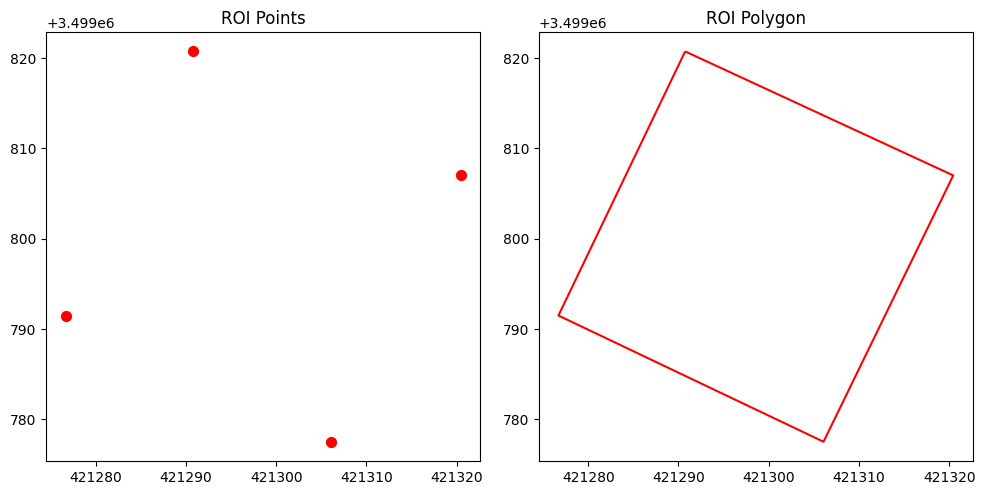

In [119]:
# Extract the Region of Interest (ROI)
polygon_shapefile_path_dormancy, _ = make_polygon(rtk_shapefile_path, uav_dormancy_image_path)

In [120]:
# Point Cloud Denoising
denoised_las_file_path_dormancy, las_name_dormancy = denoising(uav_dormancy_las_path, polygon_shapefile_path_dormancy)

.\whitebox_tools.exe --run="ClipLidarToPolygon" --input='E:\Pear\UAV\Dormancy Stage\uav_dormancy.las' --polygons='E:\Pear\ROI_Points\UAV\polygon.shp' --output='E:\Pear\UAV\Dormancy Stage\roi_uav_dormancy.las' -v --compress_rasters=False

*********************************
* Welcome to ClipLidarToPolygon *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Performing clip...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progres

In [121]:
# Ground Filtering
ground_points_file_path_dormancy = ground_filtering(denoised_las_file_path_dormancy, resolution=0.1, threshold=0.2)

In [122]:
# Generate Canopy Height Model
ground_points_file_path_dormancy = r"E:\Pear\UAV\Dormancy Stage\manual_ground_sor_roi_uav_dormancy.las"
canopy_height_model_file_path_dormancy = make_chm(ground_points_file_path_dormancy, denoised_las_file_path_dormancy, las_name_dormancy, polygon_shapefile_path_dormancy)

.\whitebox_tools.exe --run="LidarElevationSlice" --input='E:\Pear\UAV\Dormancy Stage\sor_roi_uav_dormancy.las' --output='E:\Pear\UAV\Dormancy Stage\sor_above_roi_uav_dormancy.las' --minz='43.628' --inclassval=2 --outclassval=1 -v --compress_rasters=False

***********************************
* Welcome to lidar_elevation_slice *
************************************
reading input LiDAR file...
Performing analysis...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progr

Reading points: 88%
Reading points: 89%
Reading points: 90%
Reading points: 91%
Reading points: 92%
Reading points: 93%
Reading points: 94%
Reading points: 95%
Reading points: 96%
Reading points: 97%
Reading points: 98%
Reading points: 99%
Reading points: 100%
Performing triangulation...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progres

Progress (rec 1 of 1 part 1): 59%
Progress (rec 1 of 1 part 1): 60%
Progress (rec 1 of 1 part 1): 61%
Progress (rec 1 of 1 part 1): 62%
Progress (rec 1 of 1 part 1): 63%
Progress (rec 1 of 1 part 1): 64%
Progress (rec 1 of 1 part 1): 65%
Progress (rec 1 of 1 part 1): 66%
Progress (rec 1 of 1 part 1): 67%
Progress (rec 1 of 1 part 1): 68%
Progress (rec 1 of 1 part 1): 69%
Progress (rec 1 of 1 part 1): 70%
Progress (rec 1 of 1 part 1): 71%
Progress (rec 1 of 1 part 1): 72%
Progress (rec 1 of 1 part 1): 73%
Progress (rec 1 of 1 part 1): 74%
Progress (rec 1 of 1 part 1): 75%
Progress (rec 1 of 1 part 1): 76%
Progress (rec 1 of 1 part 1): 77%
Progress (rec 1 of 1 part 1): 78%
Progress (rec 1 of 1 part 1): 79%
Progress (rec 1 of 1 part 1): 80%
Progress (rec 1 of 1 part 1): 81%
Progress (rec 1 of 1 part 1): 82%
Progress (rec 1 of 1 part 1): 83%
Progress (rec 1 of 1 part 1): 84%
Progress (rec 1 of 1 part 1): 85%
Progress (rec 1 of 1 part 1): 86%
Progress (rec 1 of 1 part 1): 87%
Progress (rec 

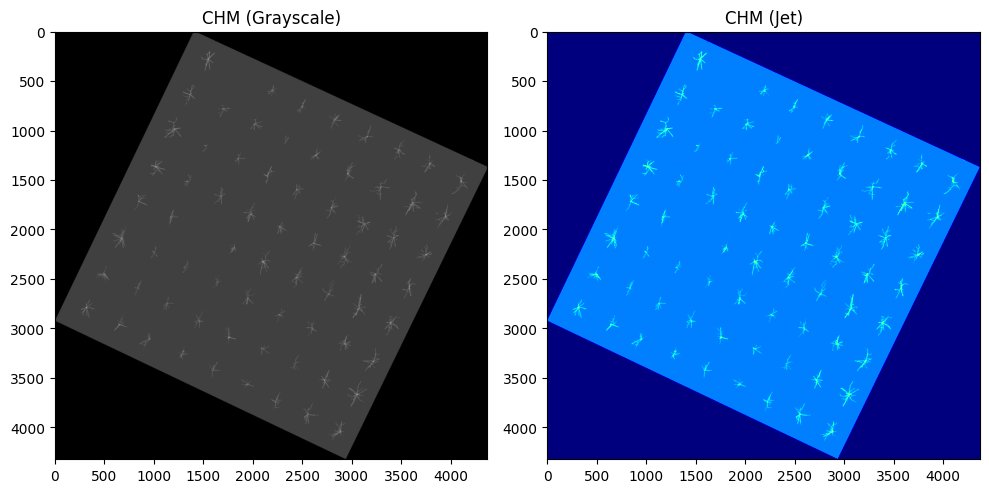

In [123]:
# Visualization
visualize_chm(canopy_height_model_file_path_dormancy)

# Drone - Flowering Stage

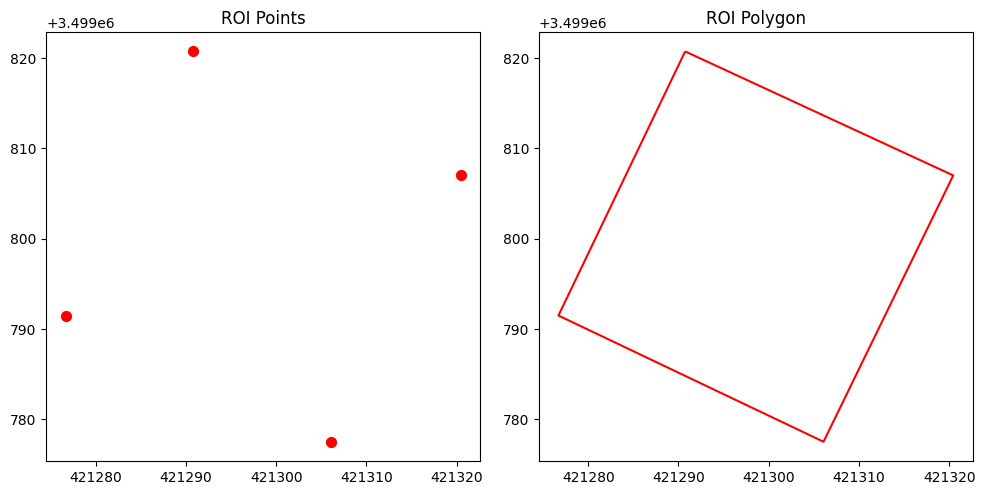

In [70]:
# Extract Region of Interest (ROI)
polygon_shapefile_path_flowering, _ = make_polygon(rtk_shapefile_path, uav_flowering_image_path)

In [71]:
# Point Cloud Denoising
denoised_las_file_path_flowering, las_name_flowering = denoising(uav_flowering_las_path, polygon_shapefile_path_flowering)

.\whitebox_tools.exe --run="ClipLidarToPolygon" --input='E:\Pear\UAV\Flowering Stage\uav_flowering.las' --polygons='E:\Pear\ROI_Points\UAV\polygon.shp' --output='E:\Pear\UAV\Flowering Stage\roi_uav_flowering.las' -v --compress_rasters=False

*********************************
* Welcome to ClipLidarToPolygon *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Performing clip...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Pro

In [72]:
# Ground Filtering
ground_points_file_path_flowering = ground_filtering(denoised_las_file_path_flowering, resolution=0.1, threshold=0.26)

In [73]:
# Generate Canopy Height Model
ground_points_file_path_flowering = r"E:\Pear\UAV\Flowering Stage\manual_ground_sor_roi_uav_flowering.las"
canopy_height_model_file_path_flowering = make_chm(ground_points_file_path_flowering, denoised_las_file_path_flowering, las_name_flowering, polygon_shapefile_path_flowering)

.\whitebox_tools.exe --run="LidarElevationSlice" --input='E:\Pear\UAV\Flowering Stage\sor_roi_uav_flowering.las' --output='E:\Pear\UAV\Flowering Stage\sor_above_roi_uav_flowering.las' --minz='43.461' --inclassval=2 --outclassval=1 -v --compress_rasters=False

***********************************
* Welcome to lidar_elevation_slice *
************************************
reading input LiDAR file...
Performing analysis...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
P

Reading points: 87%
Reading points: 88%
Reading points: 89%
Reading points: 90%
Reading points: 91%
Reading points: 92%
Reading points: 93%
Reading points: 94%
Reading points: 95%
Reading points: 96%
Reading points: 97%
Reading points: 98%
Reading points: 99%
Reading points: 100%
Performing triangulation...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
P

Progress (rec 1 of 1 part 1): 58%
Progress (rec 1 of 1 part 1): 59%
Progress (rec 1 of 1 part 1): 60%
Progress (rec 1 of 1 part 1): 61%
Progress (rec 1 of 1 part 1): 62%
Progress (rec 1 of 1 part 1): 63%
Progress (rec 1 of 1 part 1): 64%
Progress (rec 1 of 1 part 1): 65%
Progress (rec 1 of 1 part 1): 66%
Progress (rec 1 of 1 part 1): 67%
Progress (rec 1 of 1 part 1): 68%
Progress (rec 1 of 1 part 1): 69%
Progress (rec 1 of 1 part 1): 70%
Progress (rec 1 of 1 part 1): 71%
Progress (rec 1 of 1 part 1): 72%
Progress (rec 1 of 1 part 1): 73%
Progress (rec 1 of 1 part 1): 74%
Progress (rec 1 of 1 part 1): 75%
Progress (rec 1 of 1 part 1): 76%
Progress (rec 1 of 1 part 1): 77%
Progress (rec 1 of 1 part 1): 78%
Progress (rec 1 of 1 part 1): 79%
Progress (rec 1 of 1 part 1): 80%
Progress (rec 1 of 1 part 1): 81%
Progress (rec 1 of 1 part 1): 82%
Progress (rec 1 of 1 part 1): 83%
Progress (rec 1 of 1 part 1): 84%
Progress (rec 1 of 1 part 1): 85%
Progress (rec 1 of 1 part 1): 86%
Progress (rec 

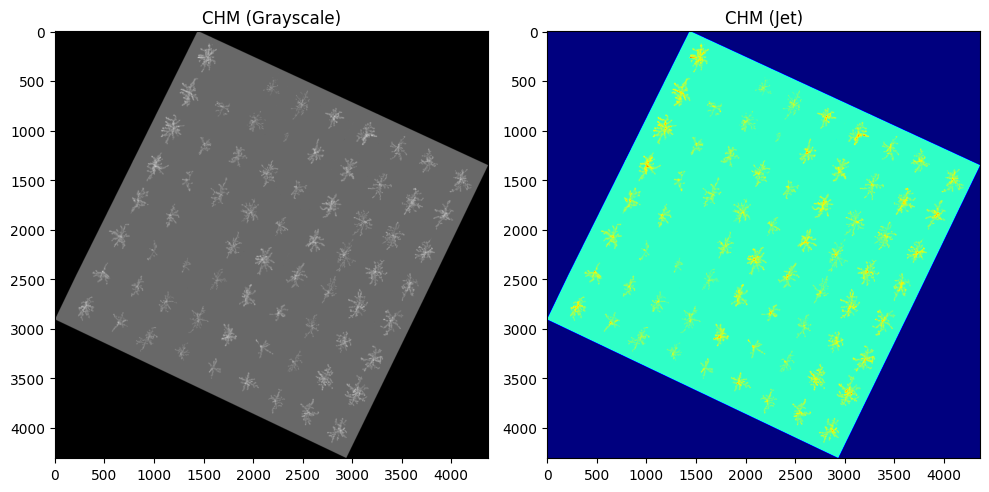

In [74]:
# Visualization
visualize_chm(canopy_height_model_file_path_flowering)

# Backpack LiDAR Point Cloud Data

In [91]:
import geopandas as gpd
from shapely.geometry import Point

In [92]:
# from txt generate shapefile
def txt_to_shp(input_txt_path, output_shp_path, epsg):
    # Read Text File
    with open(input_txt_path, 'r') as file:
        lines = file.readlines()

    # Create List of Point Coordinates
    points = []

    # Parse Each Line and Create a Point Object
    for line in lines:
        parts = line.strip().split(',')
        if len(parts) == 4:
            _, x, y, z = parts
            point = Point(float(x), float(y), float(z))
            points.append(point)

    # Create a GeoDataFrame Containing Points
    gdf = gpd.GeoDataFrame(geometry=points)

    # Set Coordinate Reference System
    gdf.crs = f'EPSG:{epsg}'

    # Save GeoDataFrame as Shapefile
    
    gdf.to_file(output_shp_path)

In [93]:
input_txt_path = r"E:\Pear\ROI_Points\Lidar\lidar_roi_points.txt"
output_shp_path = r"E:\Pear\ROI_Points\Lidar\lidar_roi_points.shp"
# The EPSG code for GDA94 is 4938
txt_to_shp(input_txt_path, output_shp_path, epsg=4938)

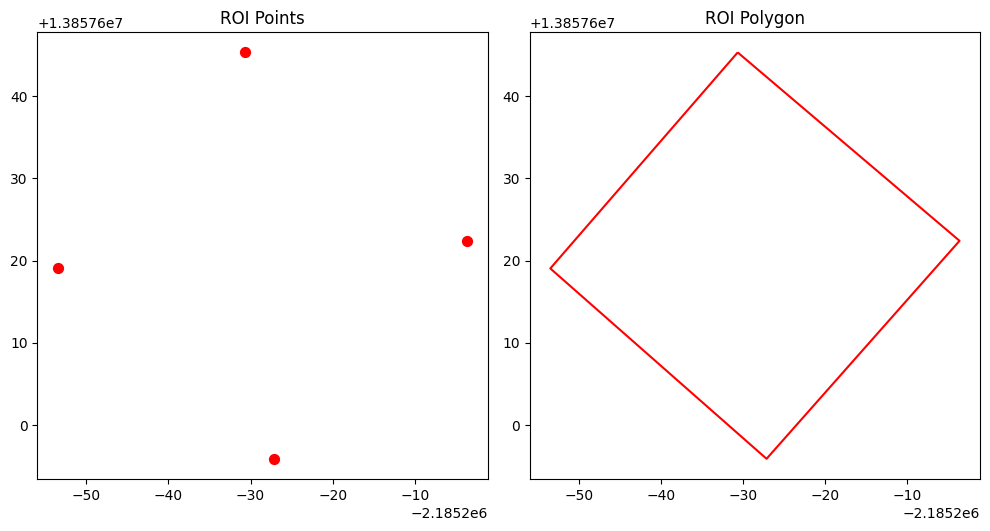

In [94]:
# Extract Region of Interest from LiDAR Point Cloud
polygon_shapefile_path_dormancy_lidar, _ = make_polygon(output_shp_path, epsg=4938)

In [95]:
lidar_dormancy_las_path = r"E:\Pear\Lidar\Dormancy Stage\lidar_dormancy.las"

In [96]:
# Point Cloud Denoising
denoised_las_file_path_dormancy_lidar, las_name_dormancy_lidar = denoising(lidar_dormancy_las_path, polygon_shapefile_path_dormancy_lidar)

.\whitebox_tools.exe --run="ClipLidarToPolygon" --input='E:\Pear\Lidar\Dormancy Stage\lidar_dormancy.las' --polygons='E:\Pear\ROI_Points\Lidar\polygon.shp' --output='E:\Pear\Lidar\Dormancy Stage\roi_lidar_dormancy.las' -v --compress_rasters=False

*********************************
* Welcome to ClipLidarToPolygon *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Performing clip...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 3

In [97]:
# Ground Filtering
ground_points_file_path_dormancy_lidar = ground_filtering(denoised_las_file_path_dormancy_lidar, resolution=1, threshold=0.5)

In [98]:
# Generate Canopy Height Model
ground_points_file_path_dormancy_lidar = r"E:\Pear\Lidar\Dormancy Stage\manual_ground_sor_roi_lidar_dormancy.las"
canopy_height_model_file_path_dormancy_lidar = make_chm(ground_points_file_path_dormancy_lidar, denoised_las_file_path_dormancy_lidar, las_name_dormancy_lidar, polygon_shapefile_path_dormancy_lidar)

.\whitebox_tools.exe --run="LidarElevationSlice" --input='E:\Pear\Lidar\Dormancy Stage\sor_roi_lidar_dormancy.las' --output='E:\Pear\Lidar\Dormancy Stage\sor_above_roi_lidar_dormancy.las' --minz='47.01' --inclassval=2 --outclassval=1 -v --compress_rasters=False

***********************************
* Welcome to lidar_elevation_slice *
************************************
reading input LiDAR file...
Performing analysis...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41

Reading points: 87%
Reading points: 88%
Reading points: 89%
Reading points: 90%
Reading points: 91%
Reading points: 92%
Reading points: 93%
Reading points: 94%
Reading points: 95%
Reading points: 96%
Reading points: 97%
Reading points: 98%
Reading points: 99%
Reading points: 100%
Performing triangulation...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
P

Progress (rec 1 of 1 part 1): 58%
Progress (rec 1 of 1 part 1): 59%
Progress (rec 1 of 1 part 1): 60%
Progress (rec 1 of 1 part 1): 61%
Progress (rec 1 of 1 part 1): 62%
Progress (rec 1 of 1 part 1): 63%
Progress (rec 1 of 1 part 1): 64%
Progress (rec 1 of 1 part 1): 65%
Progress (rec 1 of 1 part 1): 66%
Progress (rec 1 of 1 part 1): 67%
Progress (rec 1 of 1 part 1): 68%
Progress (rec 1 of 1 part 1): 69%
Progress (rec 1 of 1 part 1): 70%
Progress (rec 1 of 1 part 1): 71%
Progress (rec 1 of 1 part 1): 72%
Progress (rec 1 of 1 part 1): 73%
Progress (rec 1 of 1 part 1): 74%
Progress (rec 1 of 1 part 1): 75%
Progress (rec 1 of 1 part 1): 76%
Progress (rec 1 of 1 part 1): 77%
Progress (rec 1 of 1 part 1): 78%
Progress (rec 1 of 1 part 1): 79%
Progress (rec 1 of 1 part 1): 80%
Progress (rec 1 of 1 part 1): 81%
Progress (rec 1 of 1 part 1): 82%
Progress (rec 1 of 1 part 1): 83%
Progress (rec 1 of 1 part 1): 84%
Progress (rec 1 of 1 part 1): 85%
Progress (rec 1 of 1 part 1): 86%
Progress (rec 

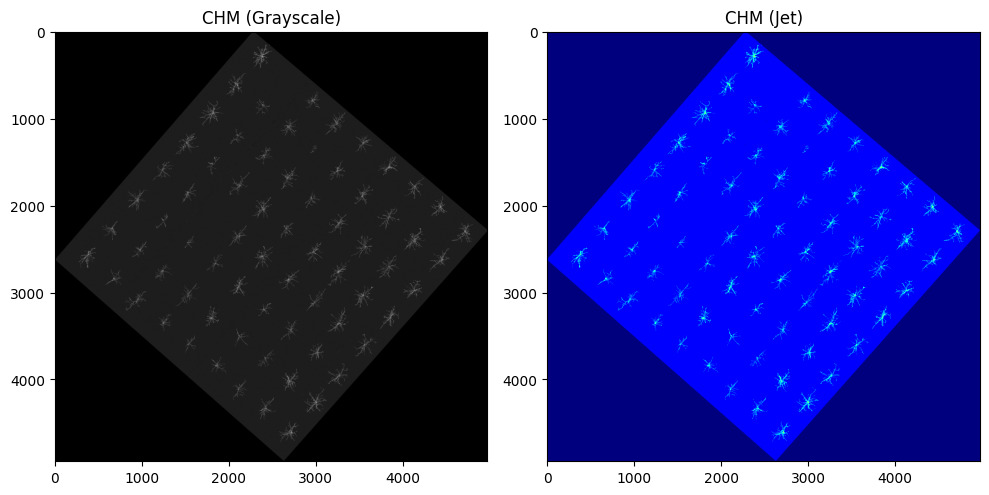

In [99]:
# Visualization
visualize_chm(canopy_height_model_file_path_dormancy_lidar)